## Alert histograms

### Imports

In [14]:
from IPython.core.display import display, HTML
from astropy.time import Time
import pandas as pd
import datetime
import json
import tqdm
from penquins import Kowalski
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# plt.style.use(['dark_background'])
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
with open('secrets_penquins.json', 'r') as f:
    secrets = json.load(f)
k = Kowalski(username=secrets['kowalski']['username'],
             password=secrets['kowalski']['password'])

In [3]:
q = {"query_type": "general_search",
     "query": "db['ZTF_alerts'].estimated_document_count()"}
r = k.query(query=q)
total = r['result_data']['query_result']
display(total)

127722228

In [13]:
d0 = datetime.datetime(2018, 2, 9)
now = datetime.datetime.utcnow()
dd = (now - d0).days
dates = [{'utc_date': (d0 + datetime.timedelta(days=ddd)),
          'utc_date_str': (d0 + datetime.timedelta(days=ddd)).strftime('%Y%m%d'),
          'jd': Time(d0 + datetime.timedelta(days=ddd)).jd,
          'total': 0,
          'programid_0': 0,
          'programid_1': 0,
          'programid_2': 0,
          'programid_3': 0} for ddd in range(dd)]

for date in tqdm.tqdm(dates):
    # total:
    qq = {"query_type": "general_search",
          "query": f"db['ZTF_alerts'].count_documents({{'candidate.jd': {{'$gt': {date['jd']},"
                    f" '$lt': {date['jd'] + 1}}}}})"}
    rr = k.query(query=qq)
    total_date = rr['result_data']['query_result']
    date['total'] = total_date
    # per programid:
    for programid in range(4):
        qq = {"query_type": "general_search",
              "query": f"db['ZTF_alerts'].count_documents({{'candidate.jd': {{'$gt': {date['jd']},"
                        f" '$lt': {date['jd'] + 1}}}, 'candidate.programid': {programid}}})"}
        rr = k.query(query=qq)
        pid_date = rr['result_data']['query_result']
        date[f'programid_{programid}'] = pid_date

# stats['total_date_programid'] = {pid: await request.app['mongo'].ZTF_alerts.count_documents({
#     'candidate.jd': {'$gt': jd_sod, '$lt': jd_sod + 1}, 'candidate.programid': pid}) for pid in range(4)}
# stats['fields'] = fields

100%|██████████| 495/495 [04:11<00:00,  1.80it/s]


In [19]:
df = pd.DataFrame.from_records(dates)
df.to_csv(f'alert_stats_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
df

,jd,programid_0,programid_1,programid_2,programid_3,total,utc_date,utc_date_str
0,2458158.5,201691,0,0,0,201691,2018-02-09,20180209
1,2458159.5,9134,0,0,0,9134,2018-02-10,20180210
2,2458160.5,107244,0,0,0,107244,2018-02-11,20180211
3,2458161.5,0,0,0,0,0,2018-02-12,20180212
4,2458162.5,0,0,0,0,0,2018-02-13,20180213
5,2458163.5,0,0,0,0,0,2018-02-14,20180214
6,2458164.5,0,0,0,0,0,2018-02-15,20180215
7,2458165.5,17843,0,0,685,18528,2018-02-16,20180216
8,2458166.5,0,0,0,0,0,2018-02-17,20180217
9,2458167.5,10,0,0,0,10,2018-02-18,20180218


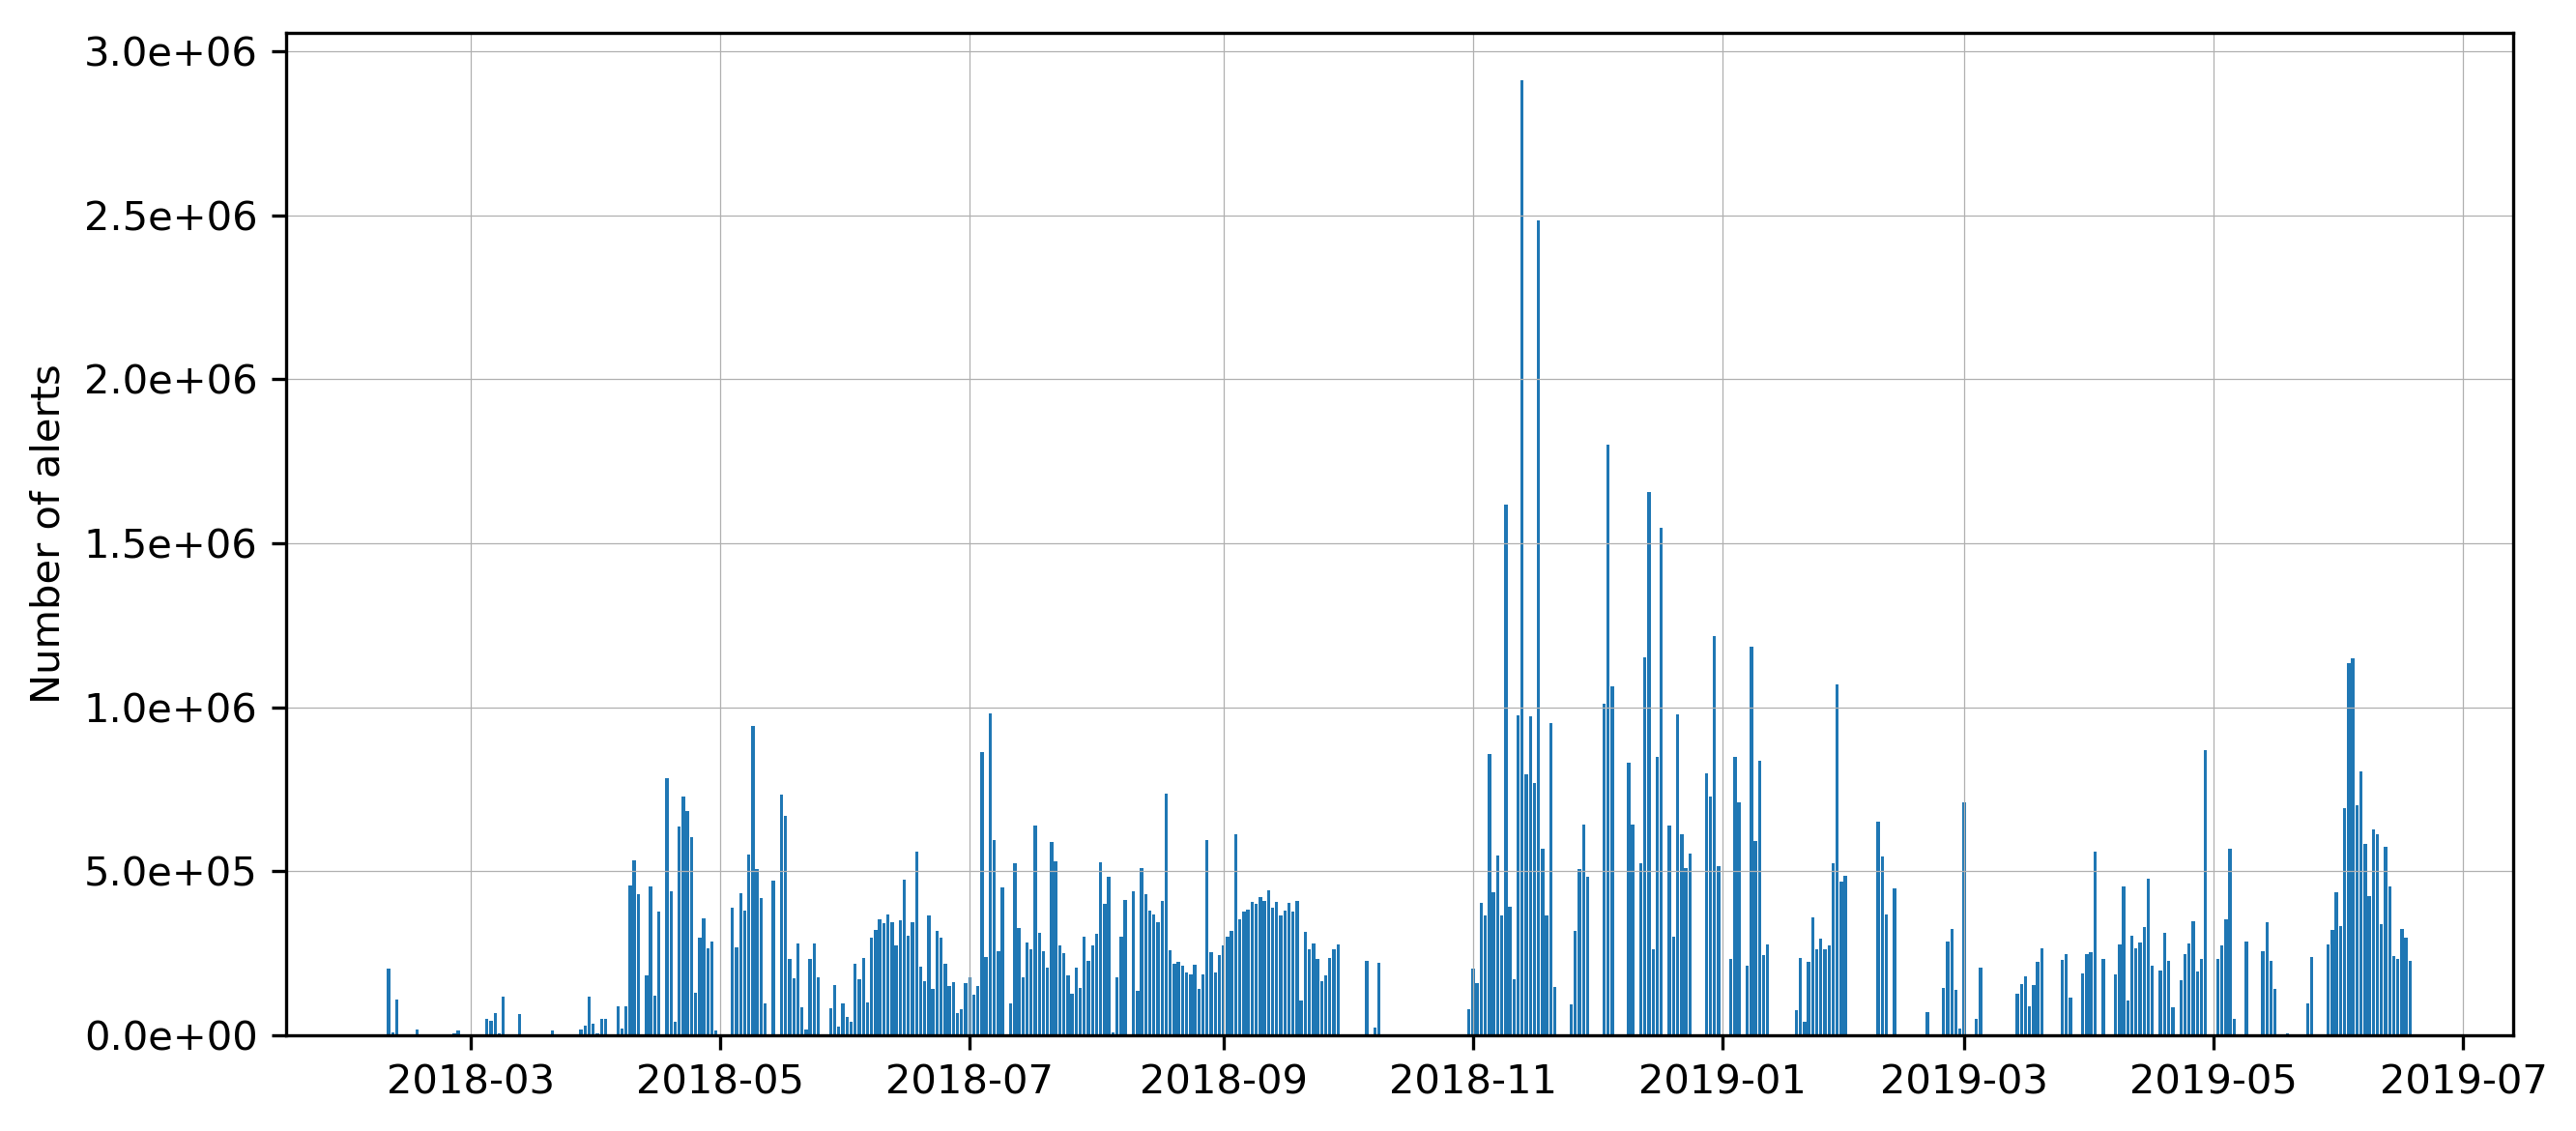

In [17]:
fig = plt.figure(figsize=(9, 4), dpi=300)
ax = fig.add_subplot(111)
ax.bar(df.utc_date, df.total)
ax.set_ylabel('Number of alerts')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
# ax.legend(loc='best')
ax.grid(True, linewidth=.3)
plt.tight_layout()